# Reinforcement learning

In this example, we are going to use a evolutionary algorithm to train a dense neural network for the gym's [BipedalWalker environment](https://gym.openai.com/envs/BipedalWalker-v2/).

![](RL-Figure1.jpg)

In [1]:
import gym
import numpy as np
import evolvepy as ep
import matplotlib.pyplot as plt

# Evaluator

To speed up the individuals evaluation, we are going to use multiple process. Because of that, we need to define a class that will act on what function we evaluate, which, as Jupyter Notebook doesn't handle multiprocessing well, we need to define it in a separate file.

The [bipedal_evaluator.py](bipedal_evaluator.py) file contains:

-  BipedalWalkerFitnessFunction: a GymFitnessFunction, evaluates the individual by making him control the agent through the environment, using the total reward obtained as fitness.

In [2]:
from bipedal_evaluator import BipedalWalkerFitnessFunction

evaluator = ep.evaluator.ProcessEvaluator(BipedalWalkerFitnessFunction)

As the environment contains random properties, the final score can vary, generating harmful noise in fitness. To deal with this problem, we're going to run 10 assessments on the same individual and then averaging and discarding the highest and lowest.

In [3]:
multiple_evaluation = ep.evaluator.MultipleEvaluation(evaluator, 10, discard_max=True, discard_min=True)

# Generator

Let's start by defining the descriptor of our individuals. Each individual will own the layer weights and bias. The number of neurons is described in the "sizes" variable. Let's put as range of each layer (-1, 1).

In [4]:
sizes = [20, 20 , 4] # Units of each layer
input_size = 24 # Network input size (= observation size)

names = []
chr_sizes = []
types = []
ranges = []

for i in range(3):
    total_weights = input_size*sizes[i]

    names.append("layer"+str(i)+"w")
    names.append("layer"+str(i)+"b")

    chr_sizes.append(total_weights)
    chr_sizes.append(sizes[i])

    ranges.append((-1.0, 1.0))
    ranges.append((-1.0, 1.0))

    types.append(np.float32)
    types.append(np.float32)

    input_size = sizes[i]

descriptor = ep.generator.Descriptor(chr_sizes, ranges, types, names)

As we are going to evaluate individuals using multiple processes, it is more efficient to use a population size multiple of the number of processors, using all of them at all times:

In [5]:
import multiprocessing as mp

population_size = (100//mp.cpu_count())*mp.cpu_count()
population_size

Let's define a generator with elitism:

In [6]:
first = ep.generator.Layer()
combine = ep.generator.CombineLayer(ep.generator.selection.tournament, ep.generator.crossover.one_point)
mutation = ep.generator.mutation.NumericMutationLayer(ep.generator.mutation.sum_mutation, 1.0, 0.9, (-0.5, 0.5))
filter0 = ep.generator.FilterFirsts(int(np.floor(0.95*population_size)))
sort = ep.generator.Sort()
filter1 = ep.generator.FilterFirsts(int(np.ceil(0.05*population_size)))
concat = ep.generator.Concatenate()

first.next = combine
combine.next = mutation
mutation.next = filter0
filter0.next = concat

first.next = sort
sort.next = filter1
filter1.next = concat

generator = ep.generator.Generator(first_layer=first, last_layer=concat, descriptor=descriptor)


To avoid getting stuck in some generation, we're also going to use dynamic mutation.

In [7]:
dyn_mut = ep.callbacks.DynamicMutation([mutation.name], refinement_patience=5, exploration_patience=5, refinement_steps=5)

evolver = ep.Evolver(generator, multiple_evaluation, population_size, [dyn_mut])

# Evolve and results

Let's evolve our generation:

In [8]:
hist, last_pop = evolver.evolve(500)

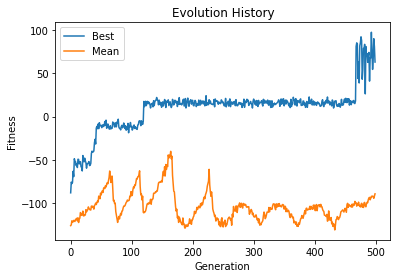

In [74]:
plt.plot(hist.max(axis=1))
plt.plot(np.mean(hist, axis=1))
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Evolution History")
plt.legend(["Best", "Mean"])
plt.show()

Looking at the fitness history, we can see that the algorithm managed to evolve our population. Realize how fitness has a noise, not using multiple assessments makes it even greater, hindering evolution. Variation in average fitness is one of the side effects of dynamic mutation.

![](RL-Figure2.jpg)

It is interesting to note that our population changes drastically at times. This phenomenon is called evolutionary steps.

We were able to see the best individual reached a maximum fitness of ~70. The score needed to go through the environment is 300. We could further improve our agent by:
- Evolve for more generations
- Changing the Neural Network Architecture
- Change the generation or evaluation scheme

We can record a video of our best individual:

In [35]:
best = last_pop[np.argmax(hist[-1])]
test_evaluator = BipedalWalkerFitnessFunction(save=True)
test_evaluator([best])

Clicking on the picture below you can see a video with the best individuals after each evolutionary step:

[![](RL-Figure1.Jpg)](https://youtu.be/WwIoEMIe3ic)

Finally, by adding a WandbCallback to the evolver, we can generate a more detailed log of the evolution: [example log](https://wandb.ai/eltoncn/EvolvePy%20Example/runs/2o9vemwl?workspace=user-eltoncn).